In [1]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt

In [2]:
d = 1.4 # carbon-carbon distance
alpha = 30*np.pi/180 # carbon-carbon-carbon angle
c = 3.4 # graphene-graphene distance

In [3]:
elementary_maille = [[0, 0, 0],
                     [d, 0, 0],
                     [d * (1+np.sin(alpha)), d * np.cos(alpha), 0],
                     [d * (2+np.sin(alpha)), d * np.cos(alpha), 0]]

In [4]:
nx = 5
ny = 10
nz = 5
# for (VMD) 0.8 nm 0.4 nm sheet (2 2 1)
# 16 atoms
# 18 bonds
# 26 angles
# 37 dihedrals
# 6 impropers

In [5]:
positions = []
molecule_ids = []
cpt_layer = 1
for li in range(nz):
    for ni in range(nx):
        for mi in range(ny):
            for x0, y0, z0 in elementary_maille:
                x = x0 + ni*2*d*(1+np.sin(alpha)) + d*(1+np.sin(alpha))*(cpt_layer % 2)/2
                y = y0 + mi*2*d*np.cos(alpha) + d*(np.cos(alpha))*(cpt_layer % 2)
                z = z0 + li*c
                positions.append([x, y, z])
                molecule_ids.append(cpt_layer)
    cpt_layer += 1
# for comparison with VMD
#positions = np.array(positions)
#size_x = np.max(np.array(positions).T[0]) - np.min(np.array(positions).T[0])
#max_pos = np.max(positions.T[0])
#new_positions = []
#for x, y, z in positions:
#    if x == max_pos:
#        x -= size_x + d * np.sin(alpha)
#    new_positions.append([x, y, z])
#positions = new_positions
############################
positions = np.array(positions)
atom_ids = np.arange(len(positions))+1
atom_charge = np.zeros(len(positions))
atom_types = np.ones(len(positions))*5
cpt_atoms = len(positions)
Lx = 21.0 # np.max(np.array(positions).T[0])-np.min(np.array(positions).T[0])+d/2
Ly = 24.25 # np.max(np.array(positions).T[1])-np.min(np.array(positions).T[1])+d*np.cos(alpha)
Lz = 44 + li*c
box = np.array([Lx, Ly, Lz])
print("Lx =", np.round(Lx,2), "A - Ly = ", np.round(Ly,2), "A - Lz = ", np.round(Lz,2), "A")
print(cpt_atoms, "atoms")

Lx = 21.0 A - Ly =  24.25 A - Lz =  57.6 A
1000 atoms


In [6]:
# recenter graphene
for myposition in positions:
    myposition[2] -= Lz/2 + 6.8

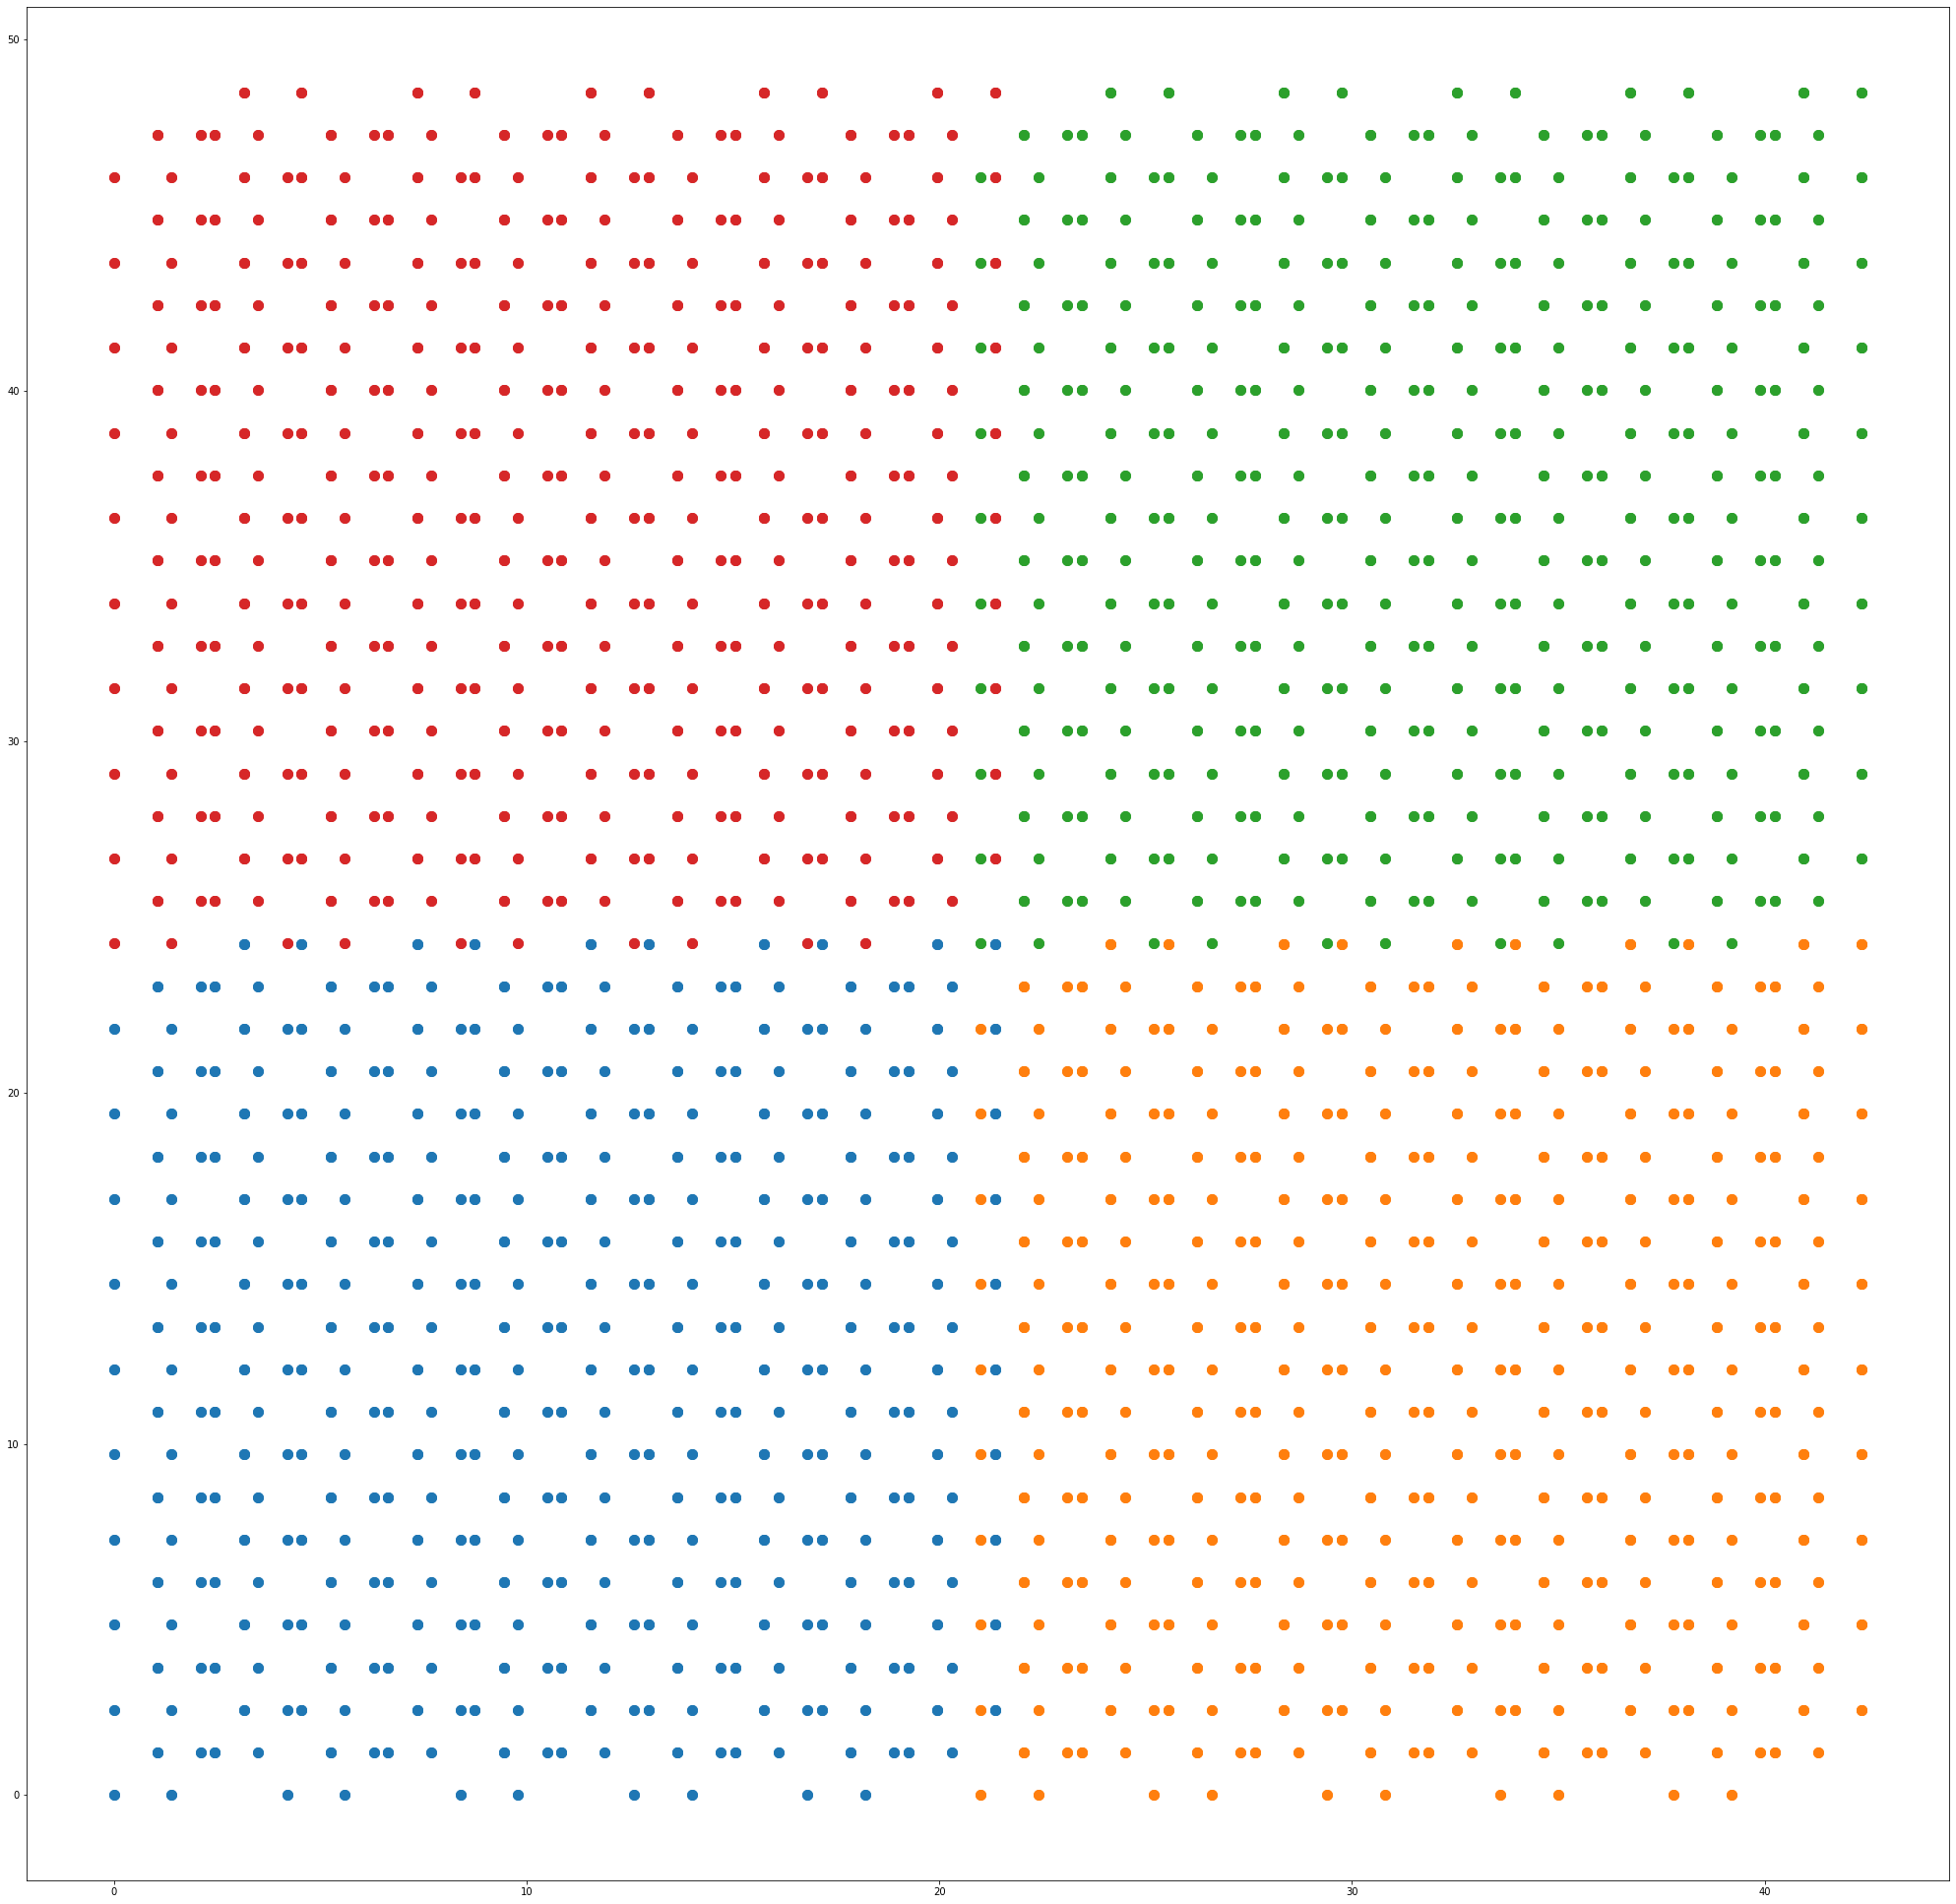

In [7]:
fig = plt.figure(figsize=(35,35))
plt.plot(positions.T[0], positions.T[1], '.', markersize = 20)
plt.plot(positions.T[0]+Lx, positions.T[1], '.', markersize = 20)
plt.plot(positions.T[0]+Lx, positions.T[1]+Ly, '.', markersize = 20)
plt.plot(positions.T[0], positions.T[1]+Ly, '.', markersize = 20)

In [8]:
bonds = []
for pos_atom_i, id_i in zip(positions, atom_ids):
    dr = norm(np.remainder(positions - pos_atom_i + box/2., box) - box/2., axis=1)
    neighbor_ids = atom_ids[(dr<1.5) & (dr>0)]
    for id_j in neighbor_ids:
        if id_i<id_j:
            bonds.append([id_i, id_j])
bonds = np.array(bonds)
cpt_bond = len(bonds)
bond_id = np.arange(cpt_bond)+1
bond_type = np.ones(cpt_bond)*3
print(cpt_bond, "bonds")

1500 bonds


In [9]:
angles = []
for id_i in atom_ids:
    neighbor_ids = bonds[bonds.T[1] == id_i].T[0].tolist() + bonds[bonds.T[0] == id_i].T[1].tolist()
    for id_j in neighbor_ids:
        for id_k in neighbor_ids:
            if id_j<id_k:
                angles.append([id_j, id_i, id_k])
angles = np.array(angles)
cpt_angle = len(angles)
angle_id = np.arange(cpt_angle)+1
angle_type = np.ones(cpt_angle)*3
print(cpt_angle, "angles")

3000 angles


In [10]:
dihedrals = []
for id_i, id_j, id_k in angles:
    k_neighbor_ids = bonds[bonds.T[1] == id_k].T[0].tolist() + bonds[bonds.T[0] == id_k].T[1].tolist()
    for id_l in k_neighbor_ids:
        if id_j != id_l:
            dihedrals.append([id_i, id_j, id_k, id_l])
    i_neighbor_ids = bonds[bonds.T[1] == id_i].T[0].tolist() + bonds[bonds.T[0] == id_i].T[1].tolist()
    for id_l in i_neighbor_ids:
        if id_j != id_l:
            dihedrals.append([id_l, id_i, id_j, id_k])
# re-order
for cpt, mydihedrals in enumerate(dihedrals):
    if mydihedrals[2] < mydihedrals[1]:
        mydihedrals = [mydihedrals[3], mydihedrals[2], mydihedrals[1], mydihedrals[0]]
    dihedrals[cpt] = mydihedrals
dihedrals = np.unique(dihedrals, axis=0)
cpt_dihedrals = len(dihedrals)
dihedrals_id = np.arange(cpt_dihedrals)+1
dihedrals_type = np.ones(cpt_dihedrals)
print(cpt_dihedrals, "dihedrals")

6000 dihedrals


In [11]:
impropers = []
for id_i, id_j in bonds:
    xi, yi, zi = positions[id_i-1]
    xj, yj, zj = positions[id_j-1]
    if yi == yj: # horizontal bond
        # improper with i in the center
        neighbor = np.unique(angles[angles.T[1] == id_i])
        if len(neighbor) == 4:
            neighbor = neighbor.tolist()
            neighbor.remove(id_i)
            neighbor.remove(id_j)
            impropers.append([id_i, neighbor[0], neighbor[1], id_j])
        neighbor = np.unique(angles[angles.T[1] == id_j])
        if len(neighbor) == 4:
            neighbor = neighbor.tolist()
            neighbor.remove(id_i)
            neighbor.remove(id_j)
            impropers.append([id_j, neighbor[0], neighbor[1], id_i])
impropers = np.array(impropers)
cpt_impropers = len(impropers)
impropers_id = np.arange(cpt_impropers)+1
impropers_type = np.ones(cpt_impropers)
print(cpt_impropers, "impropers")

1000 impropers


In [12]:
# ## write LAMMPS data file
f = open("graphite_raw.data", "w")
f.write('# LAMMPS data file \n\n')
f.write(str(cpt_atoms)+' atoms\n')
f.write(str(cpt_bond)+' bonds\n')
f.write(str(cpt_angle)+' angles\n')
f.write(str(cpt_dihedrals)+' dihedrals\n')
f.write(str(cpt_impropers)+' impropers\n')
f.write('\n')
f.write(str(int(5))+' atom types\n')
f.write(str(int(3))+' bond types\n')
f.write(str(int(3))+' angle types\n')
f.write(str(int(1))+' dihedral types\n')
f.write(str(int(1))+' improper types\n')
f.write('\n')
f.write(str(-Lx/2)+' '+str(Lx/2)+' xlo xhi\n')
f.write(str(-Ly/2)+' '+str(Ly/2)+' ylo yhi\n')
f.write(str(-Lz/2)+' '+str(Lz/2)+' zlo zhi\n')
f.write('\n')
f.write('Atoms\n')
f.write('\n')
for id, mol, type, charge, xyz in zip(atom_ids, molecule_ids, atom_types, atom_charge, positions):   
    x, y, z = xyz[0], xyz[1], xyz[2]
    newline = str(id)+' '+str(np.int32(mol))+' '+str(np.int32(type))+' '+str(charge)+' '+str(x)+' '+str(y)+' '+str(z)+'\n'
    f.write(newline)
f.write('\n')
f.write('Bonds\n')
f.write('\n')
for id, type, ij in zip(bond_id, bond_type, bonds):
    type = np.int32(type)
    newline = str(id)+' '+str(type)+' '+str(ij[0])+' '+str(ij[1])+'\n'
    f.write(newline)
f.write('\n')
f.write('Angles\n')
f.write('\n')
for id, type, ijk in zip(angle_id, angle_type, angles):
    type = np.int32(type)
    newline = str(id)+' '+str(type)+' '+str(ijk[0])+' '+str(ijk[1])+' '+str(ijk[2])+'\n'
    f.write(newline)
f.write('\n')
f.write('Dihedrals\n')
f.write('\n')
for id, type, ijkl in zip(dihedrals_id, dihedrals_type, dihedrals):
    type = np.int32(type)
    newline = str(id)+' '+str(type)+' '+str(ijkl[0])+' '+str(ijkl[1])+' '+str(ijkl[2])+' '+str(ijkl[3])+'\n'
    f.write(newline)
f.write('\n')
f.write('Impropers\n')
f.write('\n')
for id, type, ijkl in zip(impropers_id, impropers_type, impropers):
    type = np.int32(type)
    newline = str(id)+' '+str(type)+' '+str(ijkl[0])+' '+str(ijkl[1])+' '+str(ijkl[2])+' '+str(ijkl[3])+'\n'
    f.write(newline)
f.close()